# Introduction to BuddyBack

### Project Overview

BuddyBack is an innovative Internet of Things (IoT) solution that combines real-time computer vision analysis, haptic feedback, and web-based analytics to create a comprehensive multimodal interaction platform for proactive posture correction. The system addresses the growing need for intelligent health monitoring solutions that seamlessly integrate into daily work routines.

### Solution Architecture

The system consists of a Raspberry Pi-based edge device equipped with an Aukey PC-LM1E USB webcam for pose detection and a haptic motor for tactile feedback. The hardware integrates with a comprehensive web ecosystem built on Django REST Framework backend and NextJS Progressive Web Application frontend, connected through real-time WebSocket communication.

### Core Components

- Edge Device: Raspberry Pi 4 with USB webcam and haptic feedback system
- Computer Vision: MediaPipe framework for 2D skeleton extraction and pose analysis
- Web Platform: Responsive PWA with real-time device configuration and analytics
- Communication: WebSocket protocols enabling instant synchronization across all components

### Technical Innovation

The system leverages edge computing principles by processing computer vision locally on the Raspberry Pi, ensuring sub-200ms response times for haptic feedback while maintaining privacy. The MediaPipe framework extracts 33 skeletal landmarks to calculate neck alignment, forward head posture, and shoulder positioning metrics, generating individual body segment scores on a 0-100 scale.

Real-time synchronization through WebSocket connections allows instant parameter updates between the web interface and physical device. Users can adjust sensitivity levels and vibration intensity with immediate effect, while the system continuously streams posture data for analytics processing.

### Technology Stack

The frontend utilizes NextJS with TypeScript, TanStack Query for data management, and Tailwind CSS for responsive design. The backend implements Django REST Framework with WebSocket support, JWT authentication, and PostgreSQL database optimization. The system supports Progressive Web Application installation while maintaining full functionality through continuous connectivity requirements.

# Integrating Federated Learning into BuddyBack

### Enhanced Privacy-Preserving Analytics

Integrating Federated Learning (FL) into BuddyBack would revolutionize the system's approach to data analytics while maintaining user privacy. Instead of centralizing posture data on a single server, FL enables collaborative learning across multiple BuddyBack devices without requiring raw data transmission. Each Raspberry Pi device would train local models on individual user posture patterns, sharing only model parameters rather than sensitive biometric data.

This approach addresses growing privacy concerns in healthcare IoT applications while enabling sophisticated analytics capabilities.

The federated approach would allow BuddyBack to develop personalized posture correction models that adapt to individual anatomical variations and work habits without compromising user privacy. Local training on each device ensures that personal posture data never leaves the user's environment, while still contributing to a global understanding of postural patterns across the user community.




# BuddyBack: Federated Learning for Posture Classification

This notebook provides a comprehensive walkthrough of a federated learning system designed to classify posture data while preserving privacy across multiple clients. The system uses PyTorch Lightning and implements the FedAvg (Federated Averaging) algorithm with advanced data augmentation techniques.

## 🎯 Project Overview

**Goal**: Train a posture classification model across multiple clients without sharing raw data, maintaining privacy while achieving good performance.

**Key Features**:
- Federated learning with IID and Non-IID data distributions
- Advanced data augmentation with SMOTE and noise injection
- Real-time TensorBoard logging and visualization
- Comprehensive evaluation metrics



**Target**: Binary classification (0: Bad Posture, 1: Good Posture)

---

## 🏗️ Architecture Overview

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐ 
│ FederatedServer │    │ FederatedTrainer│    │ FederatedClient │ 
│                 │    │                 │    │                 │ 
│ • Global Model  │    │ • Orchestrates  │    │ • Local Training│ 
│ • Weight Aggreg.│    │ • Logging       │    │ • Local Eval    │ 
│ • Evaluation    │    │ • Checkpointing │    │ • Data Privacy  │ 
└─────────────────┘    └─────────────────┘    └─────────────────┘ 
         │                       │                       │        
         └───────────────────────┼───────────────────────┘        
                                 │                                
                        ┌─────────────────┐                       
                        │ PostureMLP Model│                       
                        │                 │                       
                        │ 4 → 64 → 32 → 2 │                       
                        │ Dropout         │                       
                        │ ReLU Activation │                       
                        └─────────────────┘                       
```
---

## Setup
### 📦 Required Libraries Installation
Per eseguire questo notebook, sono necessarie le seguenti librerie:

- `pandas`: per la manipolazione dei dati
- `tensorboard`: per operazioni numeriche
- `black`: per operazioni numeriche
- `seaborn`: per la visualizzazione dei dati
- `scikit-learn`: per le metriche di valutazione
- `imbalanced-learn`: per le trasformazioni dei dati
- `pytorch-lightning`: per semplificare il training dei modelli

In [14]:
!pip install -r ../requirements.txt

### Importing Required Libraries

In [15]:
import copy
import os
import sys
from typing import List, Dict
from typing import Tuple

import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
from PIL import Image


### Reproducibility

In [16]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## 📊 Dataset
We selected [Roboflow dataset](https://universe.roboflow.com/ikornproject/sitting-posture-rofqf/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true) containing labeled images of human sitting posture, categorized as either "good" or "bad". This dataset serves as the foundation for training our model to distinguish between healthy and unhealthy sitting habits.

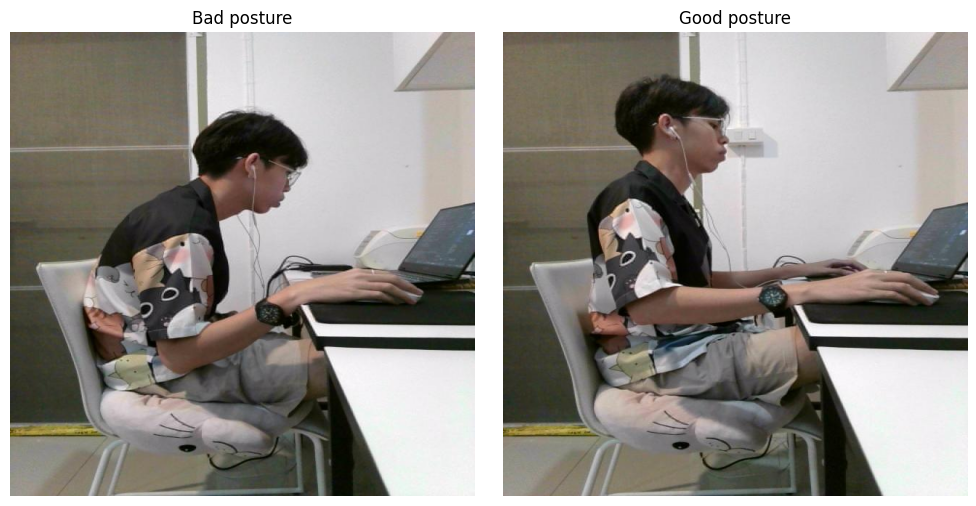

In [17]:
# Visualize two example images from the dataset: one with pneumonia and one normal

img_path1 = '../datasets/bad_posture_image.jpg'
img_path2 = '../datasets/good_posture_image.jpg'

img1 = Image.open(img_path1)
img2 = Image.open(img_path2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title('Bad posture')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Good posture')
axes[1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

# Dataset Creation and Labeling

For training and validation purposes, BuddyBack required a dataset of posture images with accurate ground truth labels. The dataset foundation was established using a publicly available posture dataset from Roboflow However, to ensure compatibility with BuddyBack's specific scoring algorithm and MediaPipe-based pose estimation pipeline, custom labeling was essential. A specialized labeling script was developed to process each image in the dataset, automatically extracting the skeletal landmarks using MediaPipe and computing the corresponding neck, torso, and shoulder scores based on BuddyBack's mathematical posture evaluation model. 

This automated labeling approach ensured consistency across the entire dataset while generating ground truth scores that directly correspond to the real-time scoring system implemented in the production device. The resulting labeled dataset provides a robust foundation for validating the accuracy of BuddyBack's pose estimation and scoring algorithms, enabling comprehensive evaluation of the system's performance across diverse postural conditions.

### Note
For implementation details, see the PostureAnalyzer class in the ```posture_classifier``` directory.

### Improvements
The dataset was then transformed into a CSV file by extracting body landmarks using MediaPipe. From these landmarks, we computed key posture-related features and this preprocessing step was essential to reduce the computational load and optimize local training, as both training and inference are performed on Raspberry Pi devices with limited hardware capabilities.

####  Structure
The project works with posture data containing 4 key features:
- `neck_angle`: Angle of the neck relative to vertical
- `torso_angle`: Angle of the torso relative to vertical
- `shoulders_offset`: Horizontal offset between shoulders
- `relative_neck_angle`: Neck angle relative to torso

In [18]:
# Load the dataset
df = pd.read_csv('../datasets/train.csv', index_col=0)

# Determine the number of classes
num_classes = df['good_posture'].nunique()

print(f"df.shape: {df.shape}")
print(f"Num classes: {num_classes}")
df.sample(5)

df.shape: (573, 4)
Num classes: 2


,torso_angle,shoulders_offset,relative_neck_angle,good_posture
neck_angle,,,,
12,-6,39.012818,18,True
24,-12,4.472136,36,False
47,7,7.615773,40,False
8,0,54.147945,8,True
27,-2,10.630146,29,False


### 🎲 Data Augmentation Strategy
Since the original dataset contained only around 600 images, we applied data augmentation techniques to increase its size and improve model generalization.
The augmentation pipeline includes multiple sophisticated techniques:

1. **Gaussian Noise**: Simulates sensor measurement noise
2. **Angle Variations**: Small random angle changes (±2°) to simulate natural movement
3. **Correlated Noise**: Realistic correlation between neck and torso angles
4. **SMOTE**: Synthetic Minority Oversampling Technique for balanced data generation
5. **Regularization Noise**: Creates "hard" examples to improve model robustness

In [19]:
class AugmentedPostureDataset(Dataset):
    """Custom dataset with real-time augmentation"""

    def __init__(
            self, features, labels, augment=True, noise_std=0.05, augment_prob=0.5
    ):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.augment = augment
        self.noise_std = noise_std
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].clone()
        y = self.labels[idx]

        if self.augment and torch.rand(1) < self.augment_prob:
            x = self._augment_sample(x)

        return x, y

    def _augment_sample(self, x):
        """Apply augmentation to a single sample"""
        augmented = x.clone()

        # 1. Add Gaussian noise to simulate sensor noise
        noise = torch.normal(0, self.noise_std, size=x.shape)
        augmented += noise

        # 2. Small angle variations (±2 degrees converted to your scale)
        angle_noise = torch.normal(0, 0.02, size=x.shape)
        augmented += angle_noise

        # 3. Simulate slight measurement inconsistencies
        # Add correlated noise between neck and torso angles (they're related)
        if len(x) >= 2:  # neck_angle and torso_angle
            correlation_noise = torch.normal(0, 0.01, size=(1,)).item()  # Get scalar value
            augmented[0] += correlation_noise  # neck_angle
            augmented[1] += correlation_noise * 0.5  # torso_angle (less correlated)

        return augmented

## DataModule class for loading and transforming images and labels.
It is designed to support federated learning with structured, posture-related CSV data. It facilitates efficient and scalable training by handling data preprocessing, augmentation, partitioning, and loading across multiple simulated clients.

In [20]:
NUM_WORKERS = 0
class FederatedPostureDataModule(pl.LightningDataModule):
    def __init__(
            self,
            csv_file: str,
            num_clients: int = 5,
            batch_size: int = 32,
            num_workers: int = NUM_WORKERS,
            iid: bool = True,
            alpha: float = 0.5,
            augment_data: bool = True,
            augment_factor: float = 2.0,  # How much to increase dataset size
            use_smote: bool = True,
            noise_std: float = 0.05,
            augment_prob: float = 0.5,
    ):
        super().__init__()
        self.csv_file = csv_file
        self.num_clients = num_clients
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.iid = iid
        self.alpha = alpha
        self.augment_data = augment_data
        self.augment_factor = augment_factor
        self.use_smote = use_smote
        self.noise_std = noise_std
        self.augment_prob = augment_prob

        self.scaler = StandardScaler()
        self.client_datasets = []
        self.test_ds = None

    def _generate_synthetic_samples(self, X, y):
        """Generate synthetic samples using multiple techniques"""
        synthetic_X, synthetic_y = [], []

        if self.use_smote and len(np.unique(y)) > 1:
            # Use SMOTE for balanced synthetic generation
            smote = SMOTE(random_state=42, k_neighbors=min(3, len(X) - 1))
            try:
                X_smote, y_smote = smote.fit_resample(X, y)
                # Only keep the synthetic samples (SMOTE returns original + synthetic)
                n_original = len(X)
                synthetic_X.append(X_smote[n_original:])
                synthetic_y.append(y_smote[n_original:])
            except ValueError:
                print("SMOTE failed, falling back to noise-based augmentation")

        # Noise-based augmentation
        n_synthetic = int(len(X) * (self.augment_factor - 1))
        if n_synthetic > 0:
            # Randomly select samples to augment
            indices = np.random.choice(len(X), size=n_synthetic, replace=True)

            for idx in indices:
                original_sample = X[idx].copy()
                original_label = y[idx]

                # Add controlled noise
                noise = np.random.normal(0, self.noise_std, size=original_sample.shape)
                synthetic_sample = original_sample + noise

                # Add some physiologically reasonable variations
                # For posture data, small angle changes are realistic
                angle_variation = np.random.normal(0, 0.02, size=original_sample.shape)
                synthetic_sample += angle_variation

                synthetic_X.append(synthetic_sample)
                synthetic_y.append(original_label)

        if synthetic_X:
            if len(synthetic_X) == 1:
                return synthetic_X[0], np.array(synthetic_y)
            else:
                return np.vstack(synthetic_X), np.hstack(synthetic_y)
        else:
            return np.array([]), np.array([])

    def _add_regularization_noise(self, X, y):
        """Add regularization through controlled data corruption"""
        noisy_X = []
        noisy_y = []

        # Create "hard" examples by adding more noise to some samples
        n_hard_examples = int(len(X) * 0.1)  # 10% hard examples
        hard_indices = np.random.choice(len(X), size=n_hard_examples, replace=False)

        for idx in hard_indices:
            sample = X[idx].copy()
            label = y[idx]

            # Add stronger noise to create challenging examples
            strong_noise = np.random.normal(0, self.noise_std * 2, size=sample.shape)
            noisy_sample = sample + strong_noise

            noisy_X.append(noisy_sample)
            noisy_y.append(label)

        return np.array(noisy_X), np.array(noisy_y)

    def setup(self, stage: str) -> None:
        # Load original data
        df = pd.read_csv(self.csv_file)
        X_original = df[
            ["neck_angle", "torso_angle", "shoulders_offset", "relative_neck_angle"]
        ].values
        y_original = df["good_posture"].astype(int).values

        print(f"Original dataset size: {len(X_original)}")

        # Apply augmentation if enabled
        if self.augment_data and stage == "fit":
            # Generate synthetic samples
            X_synthetic, y_synthetic = self._generate_synthetic_samples(
                X_original, y_original
            )

            # Add regularization noise
            X_noisy, y_noisy = self._add_regularization_noise(X_original, y_original)

            # Combine all data
            X_combined = [X_original]
            y_combined = [y_original]

            if len(X_synthetic) > 0:
                X_combined.append(X_synthetic)
                y_combined.append(y_synthetic)
                print(f"Added {len(X_synthetic)} synthetic samples")

            if len(X_noisy) > 0:
                X_combined.append(X_noisy)
                y_combined.append(y_noisy)
                print(f"Added {len(X_noisy)} noisy regularization samples")

            X = np.vstack(X_combined)
            y = np.hstack(y_combined)

            print(
                f"Augmented dataset size: {len(X)} (factor: {len(X) / len(X_original):.2f}x)"
            )
        else:
            X, y = X_original, y_original

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        if stage == "fit":
            # Partition data across clients
            if self.iid:
                client_indices = self._partition_data_iid(len(X_scaled))
            else:
                client_indices = self._partition_data_non_iid(y)

            # Create client datasets with augmentation
            self.client_datasets = []
            for indices in client_indices:
                if len(indices) > 0:
                    client_X = X_scaled[indices]
                    client_y = y[indices]

                    # Create augmented dataset for this client
                    client_dataset = AugmentedPostureDataset(
                        client_X,
                        client_y,
                        augment=self.augment_data,
                        noise_std=self.noise_std,
                        augment_prob=self.augment_prob,
                    )
                    self.client_datasets.append(client_dataset)
                else:
                    # Fallback for empty client
                    self.client_datasets.append(
                        AugmentedPostureDataset(X_scaled[:1], y[:1], augment=False)
                    )

        if stage == "test":
            # Don't augment test data
            self.test_ds = TensorDataset(
                torch.FloatTensor(X_scaled), torch.LongTensor(y)
            )

    def _partition_data_iid(self, dataset_size: int) -> List[List[int]]:
        """Partition data indices in IID manner"""
        indices = np.random.permutation(dataset_size)
        client_indices = np.array_split(indices, self.num_clients)
        return [idx.tolist() for idx in client_indices]

    def _partition_data_non_iid(self, labels: np.ndarray) -> List[List[int]]:
        """Partition data indices in non-IID manner using Dirichlet distribution"""
        num_classes = len(np.unique(labels))
        client_indices = [[] for _ in range(self.num_clients)]

        for class_id in range(num_classes):
            class_indices = np.where(labels == class_id)[0]
            np.random.shuffle(class_indices)

            proportions = np.random.dirichlet(np.repeat(self.alpha, self.num_clients))
            proportions = np.cumsum(proportions)

            start_idx = 0
            for client_id in range(self.num_clients):
                end_idx = int(proportions[client_id] * len(class_indices))
                client_indices[client_id].extend(class_indices[start_idx:end_idx])
                start_idx = end_idx

        for client_id in range(self.num_clients):
            np.random.shuffle(client_indices[client_id])

        return client_indices

    def get_client_dataloader(self, client_id: int) -> DataLoader:
        """Get dataloader for specific client"""
        if client_id >= len(self.client_datasets):
            raise ValueError(
                f"Client {client_id} does not exist. Only {len(self.client_datasets)} clients available."
            )

        return DataLoader(
            self.client_datasets[client_id],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=True if self.num_workers > 0 else False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True if self.num_workers > 0 else False,
        )

    def get_client_data_info(self) -> dict:
        """Get information about data distribution across clients"""
        info = {}
        for i, dataset in enumerate(self.client_datasets):
            # Count labels in the dataset
            labels = [dataset.labels[j].item() for j in range(len(dataset))]
            unique, counts = np.unique(labels, return_counts=True)
            info[f"client_{i}"] = {
                "total_samples": len(dataset),
                "class_distribution": dict(zip(unique.tolist(), counts.tolist())),
            }
        return info

### 🔍 Model Architecture Explanation

The `PostureMLP` is a PyTorch Lightning module with the following key components:

1. **Input Layer**: 4 features (neck angle, torso angle, shoulders offset, relative neck angle)
2. **Hidden Layers**: 64 → 32 neurons with ReLU activation and dropout (0.2) for regularization
3. **Output Layer**: 2 neurons for binary classification (good/bad posture)
4. **Loss Function**: CrossEntropyLoss for multi-class classification
5. **Metrics**: Accuracy tracking for train/validation/test phases
6. **Visualization**: Automatic confusion matrix and feature distribution logging


In [21]:
class PostureMLP(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()

        # Save hyperparameters
        self.save_hyperparameters()

        # Define the MLP architecture
        self.fc1 = nn.Linear(4, 64)  # 4 input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 classes for binary classification
        self.dropout = nn.Dropout(0.2)

        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Define metrics for tracking accuracy
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        # Confusion matrix for test evaluation
        self.confusion_matrix = ConfusionMatrix(task="binary")

        # Store learning rate
        self.learning_rate = learning_rate

        # Class names for visualization
        self.class_names = ["Bad Posture", "Good Posture"]

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        # This defines what happens in one training step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)

        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        # Log histograms every 100 steps
        if batch_idx % 100 == 0:
            for name, param in self.named_parameters():
                if param.grad is not None:
                    self.logger.experiment.add_histogram(
                        f"weights/{name}", param, self.global_step
                    )
                    self.logger.experiment.add_histogram(
                        f"gradients/{name}", param.grad, self.global_step
                    )

        return loss

    def validation_step(self, batch, batch_idx):
        # This defines what happens in one validation step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)

        # Log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        # This defines what happens in one test step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.test_accuracy(preds, y)

        # Update confusion matrix
        self.confusion_matrix.update(preds, y)

        # Log metrics
        self.log("test_loss", loss)
        self.log("test_acc", acc)

        return loss

    def on_validation_epoch_end(self):
        # Log feature distributions every 5 epochs
        if self.current_epoch % 5 == 0:
            try:
                # Get validation dataloader
                val_dataloader = self.trainer.datamodule.val_dataloader()

                # Get a batch of validation data
                batch = next(iter(val_dataloader))
                features, labels = batch
                features = features[:100]  # Take first 100 samples
                labels = labels[:100]

                # Move to device
                features = features.to(self.device)

                # Get predictions
                with torch.no_grad():
                    logits = self(features)
                    preds = torch.argmax(logits, dim=1)

                # Create feature distribution plot
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                feature_names = [
                    "Neck Angle",
                    "Torso Angle",
                    "Shoulders Offset",
                    "Relative Neck Angle",
                ]

                for i, (ax, feature_name) in enumerate(zip(axes.flat, feature_names)):
                    good_posture_mask = labels == 1
                    bad_posture_mask = labels == 0

                    ax.hist(
                        features[good_posture_mask, i].cpu().numpy(),
                        alpha=0.7,
                        label="Good Posture",
                        bins=20,
                        color="green",
                    )
                    ax.hist(
                        features[bad_posture_mask, i].cpu().numpy(),
                        alpha=0.7,
                        label="Bad Posture",
                        bins=20,
                        color="red",
                    )
                    ax.set_title(f"{feature_name} Distribution")
                    ax.legend()
                    ax.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.suptitle(
                    f"Feature Distributions - Epoch {self.current_epoch}", y=1.02
                )

                # Log to tensorboard
                self.logger.experiment.add_figure(
                    "feature_distributions", fig, self.current_epoch
                )
                plt.close(fig)

            except Exception as e:
                print(f"Could not log feature distributions: {e}")

    def on_test_epoch_end(self):
        # Compute and log confusion matrix
        cm = self.confusion_matrix.compute()

        # Create matplotlib figure
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(
            cm.cpu().numpy(),
            annot=True,
            fmt="d",
            ax=ax,
            xticklabels=self.class_names,
            yticklabels=self.class_names,
        )
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_title("Confusion Matrix")
        plt.tight_layout()

        # Log to tensorboard
        self.logger.experiment.add_figure("confusion_matrix", fig, self.current_epoch)
        plt.close(fig)

    def configure_optimizers(self):
        # Define the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def on_train_start(self):
        """Log model graph when training starts"""
        try:
            # Get a sample from the training dataloader
            sample_batch = next(iter(self.trainer.datamodule.train_dataloader()))
            sample_input = sample_batch[0][:1]  # Take just one sample

            # Move to same device as model
            sample_input = sample_input.to(self.device)

            # Log the model graph
            self.logger.experiment.add_graph(self, sample_input)
            print("Model graph logged to TensorBoard")

        except Exception as e:
            print(f"Could not log model graph: {e}")

## 👥 Federated Client Implementation


### 🔄 Client Workflow

Each `FederatedClient` operates in the following cycle:

1. **Model Update**: Receives global model weights from server
2. **Local Training**: Trains on local data for specified epochs
3. **Weight Extraction**: Returns updated model weights and dataset size
4. **Local Evaluation**: Measures performance on local data

The client never shares raw data - only model weights are exchanged, preserving privacy.

In [22]:

class FederatedClient:
    def __init__(self, client_id: int, model: nn.Module, dataloader: DataLoader):
        self.client_id = client_id
        self.model = copy.deepcopy(model)
        self.dataloader = dataloader
        self.dataset_size = len(dataloader.dataset)

    def update_model(self, global_weights: Dict):
        """Update local model with global weights"""
        self.model.load_state_dict(global_weights)

    def local_train(
        self, epochs: int = 5, learning_rate: float = 0.001
    ) -> Tuple[Dict, int]:
        """Train model locally and return updated weights"""
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            for batch in self.dataloader:
                inputs, labels = batch

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        return copy.deepcopy(self.model.state_dict()), self.dataset_size

    def evaluate(self) -> Dict:
        """Evaluate local model"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in self.dataloader:
                inputs, labels = batch
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total if total > 0 else 0
        avg_loss = total_loss / len(self.dataloader) if len(self.dataloader) > 0 else 0

        return {"accuracy": accuracy, "loss": avg_loss}


## 🌐 Federated Server Implementation


### ⚖️ FedAvg Algorithm Implementation

The server implements the **Federated Averaging (FedAvg)** algorithm:

$$
\mathbf{w}_{\text{global}} = \sum_{k=1}^{K} \left( \frac{n_k}{n_{\text{total}}} \cdot \mathbf{w}_k \right)
$$

- $\mathbf{w}_{\text{global}}$: aggregated global model
- $\mathbf{w}_k$: model from client $k$
- $n_k$: number of samples at client $k$
- $n_{\text{total}} = \sum_{k=1}^{K} n_k$: total number of samples
- $K$: total number of clients


In [23]:
import torch
import torch.nn as nn
import numpy as np
import copy
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class FederatedServer:
    def __init__(
        self,
        model: nn.Module,
        num_clients: int,
        client_fraction: float = 1.0,
        logger: TensorBoardLogger = None,
    ):
        self.global_model = model
        self.num_clients = num_clients
        self.client_fraction = client_fraction
        self.round_history = []

        # TensorBoard integration
        self.logger = logger
        if self.logger:
            self.writer = self.logger.experiment
        else:
            # Fallback to direct SummaryWriter
            self.writer = SummaryWriter(log_dir="logs/federated_learning")
        
        # Class names for confusion matrix
        self.class_names = ["Bad Posture", "Good Posture"]

    def select_clients(self, round_num: int) -> List[int]:
        """Select subset of clients for this round"""
        num_selected = max(1, int(self.client_fraction * self.num_clients))
        np.random.seed(round_num)
        selected_clients = np.random.choice(
            range(self.num_clients), size=num_selected, replace=False
        ).tolist()
        return selected_clients

    def aggregate_weights(
        self,
        client_weights: List[Dict[str, torch.Tensor]],
        client_sizes: List[int],
    ) -> Dict[str, torch.Tensor]:
        if len(client_weights) == 0:
            raise ValueError("No client weights provided.")

        total_samples = sum(client_sizes)
        if total_samples == 0:
            raise ValueError("Sum of client_sizes must be > 0.")

        # Initialise every parameter tensor to zeros on the same device/dtype
        aggregated = {k: torch.zeros_like(v) for k, v in client_weights[0].items()}

        # Size-weighted accumulation
        with torch.no_grad():  # gradients not required
            for state_dict, n in zip(client_weights, client_sizes):
                weight = n / total_samples  # proportion of samples
                for k in aggregated.keys():  # accumulate every layer
                    aggregated[k] += weight * state_dict[k]

        return aggregated

    def update_global_model(self, aggregated_weights: Dict):
        """Update global model with aggregated weights"""
        self.global_model.load_state_dict(aggregated_weights)

    def get_global_weights(self) -> Dict:
        """Get current global model weights"""
        return copy.deepcopy(self.global_model.state_dict())

    def evaluate_global_model(self, test_dataloader, round_num: int) -> Dict:
        """Evaluate global model on test data and log to TensorBoard"""
        self.global_model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        # For confusion matrix
        all_predictions = []
        all_targets = []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in test_dataloader:
                inputs, labels = batch
                outputs = self.global_model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect predictions and targets for confusion matrix
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(test_dataloader)

        # Log to TensorBoard
        self.writer.add_scalar("Global/Accuracy", accuracy, round_num)
        self.writer.add_scalar("Global/Loss", avg_loss, round_num)
        
        # Log confusion matrix every 5 rounds
        if round_num % 5 == 0:
            self.log_confusion_matrix(all_predictions, all_targets, round_num)

        return {"accuracy": accuracy, "loss": avg_loss}

    def log_confusion_matrix(self, predictions, targets, round_num):
        """Create and log confusion matrix to TensorBoard"""
        try:
            # Compute confusion matrix
            cm = confusion_matrix(targets, predictions)
            
            # Create matplotlib figure
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                ax=ax,
                xticklabels=self.class_names,
                yticklabels=self.class_names,
                cmap='Blues'
            )
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
            ax.set_title(f"Global Model Confusion Matrix - Round {round_num}")
            plt.tight_layout()
            
            # Log to tensorboard
            self.writer.add_figure("Global_Model/Confusion_Matrix", fig, round_num)
            plt.close(fig)
            
            print(f"  Confusion matrix logged for round {round_num}")
            
        except Exception as e:
            print(f"  Error logging confusion matrix: {e}")

    def log_client_metrics(
        self,
        client_accuracies: List[float],
        client_losses: List[float],
        selected_clients: List[int],
        round_num: int,
    ):
        """Log individual client metrics to TensorBoard"""
        avg_client_acc = np.mean(client_accuracies)
        avg_client_loss = np.mean(client_losses)

        # Log average client metrics
        self.writer.add_scalar("Clients/Average_Accuracy", avg_client_acc, round_num)
        self.writer.add_scalar("Clients/Average_Loss", avg_client_loss, round_num)

        # Log individual client metrics
        for i, (client_id, acc, loss) in enumerate(
            zip(selected_clients, client_accuracies, client_losses)
        ):
            self.writer.add_scalar(f"Client_{client_id}/Accuracy", acc, round_num)
            self.writer.add_scalar(f"Client_{client_id}/Loss", loss, round_num)

    def log_model_weights(self, round_num: int):
        """Log model weight histograms to TensorBoard"""
        for name, param in self.global_model.named_parameters():
            self.writer.add_histogram(f"Global_Weights/{name}", param, round_num)
    
    def evaluate_and_log_detailed_metrics(self, test_dataloader, round_num: int):
        """Extended evaluation with per-class metrics"""
        self.global_model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        # For per-class metrics
        class_correct = [0, 0]
        class_total = [0, 0]
        all_predictions = []
        all_targets = []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in test_dataloader:
                inputs, labels = batch
                outputs = self.global_model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect for confusion matrix
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
                
                # Per-class accuracy
                for i in range(len(labels)):
                    label = labels[i]
                    class_total[label] += 1
                    if predicted[i] == label:
                        class_correct[label] += 1

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(test_dataloader)
        
        # Calculate per-class accuracies
        class_accuracies = [100 * class_correct[i] / max(class_total[i], 1) for i in range(2)]

        # Log standard metrics
        self.writer.add_scalar("Global/Accuracy", accuracy, round_num)
        self.writer.add_scalar("Global/Loss", avg_loss, round_num)
        
        # Log per-class accuracies  
        self.writer.add_scalar("Global/Bad_Posture_Accuracy", class_accuracies[0], round_num)
        self.writer.add_scalar("Global/Good_Posture_Accuracy", class_accuracies[1], round_num)
        
        # Log confusion matrix
        self.log_confusion_matrix(all_predictions, all_targets, round_num)

        return {
            "accuracy": accuracy, 
            "loss": avg_loss,
            "class_accuracies": class_accuracies,
            "confusion_matrix": confusion_matrix(all_targets, all_predictions)
        }

## 🎯 Federated Trainer - Orchestrating Everything


The `FederatedTrainer` coordinates the entire federated learning process:

1. **Initialization**: Sets up data module, model, server, and clients
2. **Client Selection**: Randomly selects clients for each round
3. **Local Training**: Selected clients train on their local data
4. **Weight Aggregation**: Server aggregates client weights using FedAvg
5. **Global Evaluation**: Tests the global model on centralized test data
6. **Logging**: Records metrics to TensorBoard for visualization
7. **Checkpointing**: Saves model states periodically


In [24]:
class FederatedTrainer:
    def __init__(
        self,
        csv_file: str,
        num_clients: int = 5,
        num_rounds: int = 50,
        local_epochs: int = 5,
        client_fraction: float = 1.0,
        learning_rate: float = 0.001,
        batch_size: int = 32,
        iid: bool = True,
        save_dir: str = "logs",
        experiment_name: str = "federated_posture",
    ):
        self.csv_file = csv_file
        self.num_clients = num_clients
        self.num_rounds = num_rounds
        self.local_epochs = local_epochs
        self.client_fraction = client_fraction
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.iid = iid

        # Setup TensorBoard logger (Lightning style)
        self.logger = TensorBoardLogger(
            save_dir=save_dir,
            name=experiment_name,
            version=None,  # Auto-increment version
        )

        # Create checkpoint directory
        self.checkpoint_dir = os.path.join(self.logger.log_dir, "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Initialize components
        self.datamodule = FederatedPostureDataModule(
            csv_file=csv_file,
            num_clients=num_clients,
            batch_size=batch_size,
            iid=iid,
            augment_data=True,  # Enable augmentation
            augment_factor=10.0,  # Double the dataset size
            use_smote=True,  # Use SMOTE for balanced generation
            noise_std=1,  # Noise level
            augment_prob=0.5,  # 50% chance of augmentation per sample
        )

        self.global_model = PostureMLP()
        self.server = FederatedServer(
            self.global_model, num_clients, client_fraction, logger=self.logger
        )

        # Training history
        self.history = {
            "round": [],
            "global_accuracy": [],
            "global_loss": [],
            "client_accuracies": [],
        }

    def setup_clients(self):
        """Setup federated data and create clients"""
        self.datamodule.setup("fit")
        self.datamodule.setup("test")

        # Create clients
        self.clients = []
        for i in range(self.num_clients):
            client_dataloader = self.datamodule.get_client_dataloader(i)
            client = FederatedClient(i, self.global_model, client_dataloader)
            self.clients.append(client)

        # Log data distribution info to TensorBoard
        data_info = self.datamodule.get_client_data_info()

        # Create data distribution visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        client_ids = []
        good_posture_counts = []
        bad_posture_counts = []

        for client_id, info in data_info.items():
            client_ids.append(client_id.replace("client_", "Client "))
            good_posture_counts.append(info["class_distribution"].get(1, 0))
            bad_posture_counts.append(info["class_distribution"].get(0, 0))

        x = range(len(client_ids))
        width = 0.35

        ax.bar(
            [i - width / 2 for i in x],
            bad_posture_counts,
            width,
            label="Bad Posture",
            color="red",
            alpha=0.7,
        )
        ax.bar(
            [i + width / 2 for i in x],
            good_posture_counts,
            width,
            label="Good Posture",
            color="green",
            alpha=0.7,
        )

        ax.set_xlabel("Clients")
        ax.set_ylabel("Number of Samples")
        ax.set_title(
            f'Data Distribution Across Clients ({"IID" if self.iid else "Non-IID"})'
        )
        ax.set_xticks(x)
        ax.set_xticklabels(client_ids)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        self.logger.experiment.add_figure("Data_Distribution", fig, 0)
        plt.close(fig)

        print("Data distribution across clients:")
        for client_id, info in data_info.items():
            print(f"{client_id}: {info}")

    def train_federated(self):
        """Main federated training loop with TensorBoard logging"""
        print(f"Starting Federated Learning with {self.num_clients} clients")
        print(f"Data distribution: {'IID' if self.iid else 'Non-IID'}")
        print(f"TensorBoard logs will be saved to: {self.logger.log_dir}")
        print("-" * 60)

        test_dataloader = self.datamodule.test_dataloader()

        # Log hyperparameters
        hparams = {
            "num_clients": self.num_clients,
            "num_rounds": self.num_rounds,
            "local_epochs": self.local_epochs,
            "client_fraction": self.client_fraction,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "iid": self.iid,
        }
        self.logger.log_hyperparams(hparams)

        for round_num in range(self.num_rounds):
            print(f"Round {round_num + 1}/{self.num_rounds}")

            # Select clients for this round
            selected_clients = self.server.select_clients(round_num)
            print(f"{len(selected_clients)}/{self.num_clients} client selected")
            print(f"Selected clients: {selected_clients}")

            # Collect client updates
            client_weights = []
            client_sizes = []
            client_accuracies = []
            client_losses = []

            for client_id in selected_clients:
                client = self.clients[client_id]

                # Update client with global model
                client.update_model(self.server.get_global_weights())

                # Local training
                weights, size = client.local_train(
                    epochs=self.local_epochs, learning_rate=self.learning_rate
                )

                # Evaluate client
                client_eval = client.evaluate()

                client_weights.append(weights)
                client_sizes.append(size)
                client_accuracies.append(client_eval["accuracy"])
                client_losses.append(client_eval["loss"])

                print(
                    f"  Client {client_id}: Accuracy = {client_eval['accuracy']:.2f}%"
                )

            # Log client metrics to TensorBoard
            self.server.log_client_metrics(
                client_accuracies, client_losses, selected_clients, round_num
            )

            # Aggregate weights using FedAvg
            aggregated_weights = self.server.aggregate_weights(
                client_weights, client_sizes
            )
            self.server.update_global_model(aggregated_weights)

            # Log model weights every 5 rounds
            if round_num % 5 == 0:
                self.server.log_model_weights(round_num)

            # Evaluate global model
            # global_eval = self.server.evaluate_global_model(test_dataloader, round_num)
            global_eval = self.server.evaluate_and_log_detailed_metrics(test_dataloader, round_num)

            # Store history
            self.history["round"].append(round_num + 1)
            self.history["global_accuracy"].append(global_eval["accuracy"])
            self.history["global_loss"].append(global_eval["loss"])
            self.history["client_accuracies"].append(np.mean(client_accuracies))

            # Save checkpoint
            if round_num % 10 == 0 or round_num == self.num_rounds - 1:
                checkpoint_path = os.path.join(
                    self.logger.log_dir,
                    "checkpoints",
                    f"federated-round-{round_num:02d}-acc-{global_eval['accuracy']:.2f}.ckpt",
                )
                torch.save(
                    {
                        "round": round_num,
                        "model_state_dict": self.global_model.state_dict(),
                        "global_accuracy": global_eval["accuracy"],
                        "global_loss": global_eval["loss"],
                        "hyperparameters": hparams,
                    },
                    checkpoint_path,
                )

            print(
                f"  Global Model: Accuracy = {global_eval['accuracy']:.2f}%, Loss = {global_eval['loss']:.4f}"
            )
            print(f"  Average Client Accuracy = {np.mean(client_accuracies):.2f}%")
            print("-" * 60)

        print(f"\nFederated Training completed!")
        print(f"TensorBoard logs saved to: {self.logger.log_dir}")
        print(f"To view results, run: tensorboard --logdir={self.logger.save_dir}")


## 🚀 Running the Federated Learning System

### Hyperparameters Explained (Federated Learning Context)

- **Batch Size**: Number of samples processed together during local training updates.
- **Clients**: Number of participants training locally on their own data.
- **Rounds**: Number of federated training cycles involving local training and global aggregation.
- **Local Epochs**: How many times each client trains on their local data per round.
- **Learning Rate**: Step size used by the optimizer to update model weights during training.
- **Client Fraction**: Proportion of clients participating in each training round.
- **IID (Independent and Identically Distributed)**: Whether data is distributed evenly across clients (True) or not (False).


In [25]:
BATCH_SIZE = 64
NUM_CLIENTS = 5
NUM_ROUNDS = 30
LOCAL_EPOCHS = 5
LEARNING_RATE = 0.001
CLIENT_FRACTION = 1.0
IID= True  # Set to False for Non-IID scenario


### Experiments
1. **IID Scenario**: Even data distribution across clients
2. **Non-IID Scenario**: Skewed data distribution simulating real-world conditions


In [26]:

torch.set_float32_matmul_precision("high")

# IID Federated Learning
print("=" * 80)
print("FEDERATED LEARNING - IID")
print("=" * 80)

fed_trainer_iid = FederatedTrainer(
    csv_file="../datasets/train.csv",  # Adjust path as needed
    num_clients=NUM_CLIENTS,
    num_rounds=NUM_ROUNDS,
    local_epochs=LOCAL_EPOCHS,
    client_fraction=CLIENT_FRACTION,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    iid=IID,
    save_dir="logs",
    experiment_name="federated_posture_iid",
)

fed_trainer_iid.setup_clients()
fed_trainer_iid.train_federated()

# Non-IID Federated Learning
print("\n" + "=" * 80)
print("FEDERATED LEARNING - NON-IID")
print("=" * 80)

fed_trainer_non_iid = FederatedTrainer(
    csv_file="../datasets/train.csv",  # Adjust path as needed
    num_clients=NUM_CLIENTS,
    num_rounds=NUM_ROUNDS,
    local_epochs=LOCAL_EPOCHS,
    client_fraction=CLIENT_FRACTION,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    iid=not IID,  # Set to False for Non-IID scenario
    save_dir="logs",
    experiment_name="federated_posture_non_iid",
)

fed_trainer_non_iid.setup_clients()
fed_trainer_non_iid.train_federated()

print(f"\nAll experiments completed!")
print(f"To view all results, run: tensorboard --logdir=logs")


FEDERATED LEARNING - IID
Original dataset size: 573
Added 5362 synthetic samples
Added 57 noisy regularization samples
Augmented dataset size: 5992 (factor: 10.46x)
Original dataset size: 573
Data distribution across clients:
client_0: {'total_samples': 1199, 'class_distribution': {0: 798, 1: 401}}
client_1: {'total_samples': 1199, 'class_distribution': {0: 763, 1: 436}}
client_2: {'total_samples': 1198, 'class_distribution': {0: 796, 1: 402}}
client_3: {'total_samples': 1198, 'class_distribution': {0: 784, 1: 414}}
client_4: {'total_samples': 1198, 'class_distribution': {0: 775, 1: 423}}
Starting Federated Learning with 5 clients
Data distribution: IID
TensorBoard logs will be saved to: logs/federated_posture_iid/version_0
------------------------------------------------------------
Round 1/30
5/5 client selected
Selected clients: [2, 0, 1, 3, 4]
  Client 2: Accuracy = 87.90%
  Client 0: Accuracy = 88.24%
  Client 1: Accuracy = 87.66%
  Client 3: Accuracy = 89.65%
  Client 4: Accuracy